In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../src')

import pickle
import os
from tqdm import tqdm
import pandas as pd
from utils import get_corr_table, get_weights
from classification import apply_classifiers_original_features

dataset_name = 'orl'

In [2]:
# Read the best parameters configuration for each of the dimensionality reduction techniques
reduced_X_best = pickle.load(open(os.path.dirname(os.getcwd()) + f'/data/{dataset_name}/reduced/reduced_X_best.pkl', 'rb'))

# Read processed data
X_train = pickle.load(open(os.path.dirname(os.getcwd()) + f'/data/{dataset_name}/processed/X_train.pkl', 'rb'))
X_test = pickle.load(open(os.path.dirname(os.getcwd()) + f'/data/{dataset_name}/processed/X_test.pkl', 'rb'))
y_train = pickle.load(open(os.path.dirname(os.getcwd()) + f'/data/{dataset_name}/processed/y_train.pkl', 'rb'))
y_test = pickle.load(open(os.path.dirname(os.getcwd()) + f'/data/{dataset_name}/processed/y_test.pkl', 'rb'))


# Calculate the correlation with the original features
# Calculate variation of each component
weights = get_weights(reduced_X_best, n_components=300)

# Calculate correlation with original features
df_corrs, df_corrs_avg = get_corr_table(reduced_X_best, X_train, abs=False, weighted=True, weights=weights)
df_corrs_avg = df_corrs_avg.reset_index()

# Get lists of features indices ordered by correlation
most_correlated_pixels = {}
for key in df_corrs_avg.keys()[1:]:
    most_correlated_pixels[key] = df_corrs_avg.sort_values(by=key, ascending=False)['index'].values


In [5]:
scores = dict()  # Dictionary to store scores of different classifiers

pbar = tqdm(list(range(500, 10304, 500)) + [10304])
for num_dim in pbar:
    for dim_technique in df_corrs_avg.keys()[1:]:
        pbar.set_description(f'{dim_technique} {num_dim} Dimensions')

        # Classify with SGD
        res_sgd = apply_classifiers_original_features(
            X_train[:, most_correlated_pixels[dim_technique][:num_dim]],
            y_train,
            X_test[:, most_correlated_pixels[dim_technique][:num_dim]],
            y_test,
            dataset_name,
            classifiers=['SGD'])
        
        # Classify with SVC
        res_svc = apply_classifiers_original_features(
            X_train[:, most_correlated_pixels[dim_technique][:num_dim]],
            y_train,
            X_test[:, most_correlated_pixels[dim_technique][:num_dim]],
            y_test,
            dataset_name,
            classifiers=['SVC'])
        
        scores[(dim_technique, num_dim)] = [res_sgd, res_svc]

scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=[
    'SGD Score', 'SVC Score']).reset_index()
scores_df[['Dim Technique', 'Num Dimensions']] = scores_df['index'].apply(pd.Series)

scores_df = scores_df[['Dim Technique', 'Num Dimensions', 'SGD Score', 'SVC Score']]

# Save scores as CSV
scores_df.to_csv(os.path.dirname(os.getcwd()) + f'/results/feature_selection/{dataset_name}_scores.csv')

SLMVP 10304 Dimensions: 100%|██████████| 21/21 [38:49<00:00, 110.95s/it]


## Feature Selection Linechart

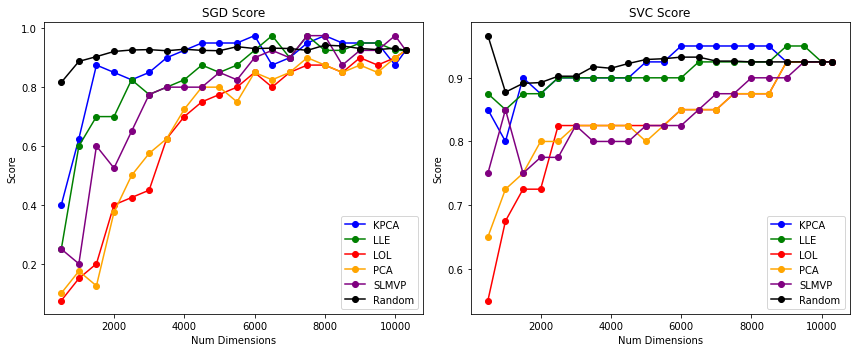

In [19]:
import matplotlib.pyplot as plt

# Read scores
scores_df = pd.read_csv(os.path.dirname(os.getcwd()) + f'/results/feature_selection/{dataset_name}_scores.csv', index_col=0)

# Read random scores
scores_random_df = pd.read_csv(os.path.dirname(os.getcwd()) + f'/results/feature_selection/{dataset_name}_scores_random.csv')

# Concatenate scores with random scores
scores_random_df['Dim Technique'] = 'Random'
scores_random_df = scores_random_df[['Dim Technique', 'Num Dimensions', 'SGD Score', 'SVC Score']]
scores_df = pd.concat([scores_df, scores_random_df])

# Define a colormap for different techniques
technique_colors = {'KPCA': 'blue', 'LLE': 'green', 'LOL': 'red', 'PCA': 'orange', 'SLMVP': 'purple', 'Random': 'black'}

# Create two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for SGD Score
for technique, color in technique_colors.items():
    subset_df = scores_df[scores_df['Dim Technique'] == technique]
    axs[0].plot(subset_df['Num Dimensions'], subset_df['SGD Score'], marker='o', linestyle='-', color=color, label=technique)

axs[0].set_title('SGD Score')
axs[0].set_xlabel('Num Dimensions')
axs[0].set_ylabel('Score')
axs[0].legend()

# Plot for SVC Score
for technique, color in technique_colors.items():
    subset_df = scores_df[scores_df['Dim Technique'] == technique]
    axs[1].plot(subset_df['Num Dimensions'], subset_df['SVC Score'], marker='o', linestyle='-', color=color, label=technique)

axs[1].set_title('SVC Score')
axs[1].set_xlabel('Num Dimensions')
axs[1].set_ylabel('Score')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
